In [ ]:
cd("/home/jm2386/Active_Lattice/")
using DrWatson
@quickactivate "Active_Lattice"
include("/home/jm2386/Active_Lattice/src/pm_pdes.jl");
include("/home/jm2386/Active_Lattice/src/pm_sims.jl");
include("/home/jm2386/Active_Lattice/src/pm_plot.jl");
include("/home/jm2386/Active_Lattice/src/Hetrocline.jl");

In [70]:
# Load initial wave
function get_stretch_param(Lx)
    param = get_grid_param(21,11)
    @unpack Nx = param
    param["save_interval"] = 100.0
    param["name"] = "soliton_stretch"
    param["Lx"] = Float64(Lx)
    param["Δx"] = Float64(Lx/Nx)
    return param
end

function get_dense_param(Lx, ΔX; save_interval = 1.0)
    param = get_stretch_param(Lx)
    @pack! param = save_interval

    while param["Δx"] > ΔX
        param = double_param(param)
    end
    return param
end

function double_param(param)
    @unpack Nx, Lx, Δx = param
    NNx = Int64(2*Nx)
    Δx = Δx/2
    Nx = NNx
    @pack! param = Δx, Nx
    return param
end

param = get_dense_param(80, 0.05)
T = 10000.0
@pack! param = T
loaded, f, t = quiet_load_last_pde(param)
i = argmax(sum(f;dims=3)[:,1])
@unpack Nx = param
f = circshift(f,((Nx÷2)-i,0));

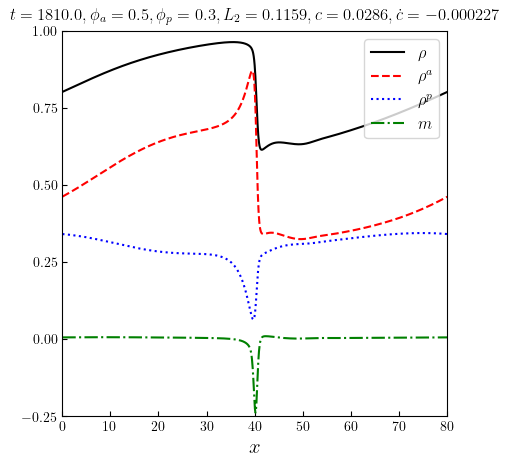

In [71]:
# Dispaly Profile
using PyPlot
PyPlot.close("all")
        rc("text", usetex=true)
        fig, ax = subplots(1,1,figsize=(5,5))
        @unpack Δx, Lx = param
        ax.plot(Δx:Δx:Lx, f[:,2]+f[:,1]+f[:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, f[:,1]+f[:,2]; 
        color = "red", linestyle = "--", label = L"\rho^a")
        ax.plot(Δx:Δx:Lx, f[:,3]; 
        color = "blue", linestyle = ":",label = L"\rho^p")
        ax.plot(Δx:Δx:Lx, f[:,2]-f[:,1]; 
        color = "green", linestyle = "-.", label = L"m")

        d2(x) = round(x; digits = 2)
        d4(x) = round(x; digits = 4)
        d6(x) = round(x; digits = 6)
        normf, c1, dc = f_dot(param, f)
        latex_string = latexstring("\$ t = $(d2(t)), \\phi_a = $(param["ϕa"]), \\phi_p = $(param["ϕp"]), L_2 = $(d4(normf)), c = $(d4(c1)), {\\dot c} = $(d6(dc))\$")
        ax.set_title(latex_string, fontsize = 12)
        ax.get_xaxis().set_ticks(0:10.0:Lx)
        ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.25)))
        ax.axis([0,Lx,-0.25,1.0])
        ax.tick_params(direction = "in")
        ax.legend(loc= "upper right", fontsize = 12)
        ax.set_xlabel(L"x", fontsize = 15)
display(fig)

In [15]:
minimum(sum(f;dims=2))

0.6381776852781776

In [67]:
param["Δx"]

0.025

In [68]:
using LaTeXStrings
function plot_phase(fig, ax, Pe; Lxs = [5,10,20])
    Pes = [Pe]
    axlims = [[0.0, 1.0, 0, 0.4]]
    axs = [ax]
    for (i,(ax, Pe, axlim)) in enumerate(zip(axs, Pes, axlims))
        # load binodal
            filename = "/store/DAMTP/jm2386/Active_Lattice/data/binodal/Pe=$(Pe).jld2"
            data = wload(filename)
            @unpack Pe, γs, ϕ1s, ϕ2s = data

        # plot binodal
            binod = ax.plot(gammas_converter_a(γs, ϕ1s), gammas_converter_p(γs, ϕ1s), color = "red", label = "Binodal")
            ax.plot(gammas_converter_a(γs, ϕ2s), gammas_converter_p(γs, ϕ2s), color = "red", label = "_Bindoal")
            #ax.plot(0.:0.1:1., 1.:-0.1:0., color = "black", label = "_Full")

            rc("text", usetex=true)
            ax.xaxis.set_tick_params(labelsize=15)
            ax.xaxis.tick_bottom()
            ax.yaxis.set_tick_params(labelsize=15)
            
            #ax.set_title(L"\Re{ \lambda_n^\mathrm{max}} = 0",fontsize=20)
            ax.set_xlabel(L"\phi^a",fontsize=20)
            ax.set_ylabel(L"\phi^p", fontsize=20)
            # ax.legend(loc = "upper right", fontsize=20)
            # ax.set_aspect(0.25*Δρ/ΔPe)
            title = latexstring("\$ \\mathrm{Pe} = $(Pe)\$")
            ax.set_title(title,fontsize=20)
            ax.tick_params(labelbottom = true, direction = "in")
        #
        # plot finite spin
                for Lx in Lxs
                    local ϕas_left, ϕas_right, ϕps
                    ϕas_left, ϕas_right, ϕps = return_spin_finite(;Pe = Pe, Δϕ = 0.001,Lx=Lx)
                    ax.plot(ϕas_left, ϕps, color = "blue", label = "_Spindoal", linestyle = "--", alpha = 0.5)
                    ax.plot(ϕas_right, ϕps, color = "blue", label = "_Spindoal", linestyle = "--", alpha = 0.5)
    
                    # find final find gamma
                    final_γ = 0.
                    final_ϕ1 = 0.
                    final_ϕ2 = 0.
                    for (γ, ϕ1, ϕ2) in zip(γs, ϕ1s, ϕ2s)
                        if (is_stable_value_finite(gamma_converter(γ, ϕ1)...; Pe = Pe, Lx=Lx)>0)|(is_stable_value_finite(gamma_converter(γ, ϕ2)...; Pe = Pe,Lx=Lx)>0)
                            final_γ = γ
                            final_ϕ1 = ϕ1
                            final_ϕ2 = ϕ2
                            break
                        end
                    end
                    # tie line
                    tie_line_x = -ϕps*final_γ/(final_γ-1).+1
                    xs = []
                    ys = []
                    for (x,y) in zip(tie_line_x,ϕps)
                        if (x+y ≤ final_ϕ2)&(x+y ≥ final_ϕ1)
                            push!(xs,x)
                            push!(ys,y)
                        end
                    end
                    ax.plot(xs,ys,color = "black", linestyle = "--", alpha = 0.5)
                end
        #
        # plot spinodal
            ϕas_left, ϕas_right, ϕps = return_spin(;Pe = Pe, Δϕ = 0.0001)
            ax.plot(ϕas_left, ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
            ax.plot(ϕas_right, ϕps, color = "blue", label = "_Spindoal", linestyle = "-")
        #
        # phase shading
        if i ==2
            ax.fill_betweenx(ϕps,ϕas_left,ϕas_right , color = "red", alpha = 0.3, linewidth = 0) 
            max_ϕa = maximum(ϕas_left)
            max_ϕp = maximum(ϕps)
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ1s).+0.00001)
            ax.fill_betweenx(ϕps,gammas_converter_a(γ_grid, ϕ1_grid),ϕas_left,(gammas_converter_a(γ_grid, ϕ1_grid) .≤ ϕas_left), color = "green", alpha = 0.3, linewidth = 0)
        
            ax.fill_betweenx(ϕps,gammas_converter_a(γ_grid, ϕ1_grid),ϕas_right,(gammas_converter_a(γ_grid, ϕ1_grid) .≥ ϕas_right), color = "green", alpha = 0.3, linewidth = 0)
        
            #ax.plot(gammas_converter_a(γ_grid, ϕ2_grid), ϕps)
            #ax.plot(ϕas_right, ϕps)
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ2s).+0.00001)
            ax.fill_betweenx(ϕps,ϕas_right,gammas_converter_a(γ_grid,ϕ2_grid ),gammas_converter_a(γ_grid, ϕ2_grid) .≥ ϕas_right, color = "green", alpha = 0.3, linewidth = 0) 
        else
            # find final find gamma
            final_γ = 0.
            final_ϕ1 = 0.
            final_ϕ2 = 0.
            for (γ, ϕ1, ϕ2) in zip(γs, ϕ1s, ϕ2s)
                if (is_stable_value(gamma_converter(γ, ϕ1)...; Pe = Pe)>0)|(is_stable_value(gamma_converter(γ, ϕ2)...; Pe = Pe)>0)
                    final_γ = γ
                    final_ϕ1 = ϕ1
                    final_ϕ2 = ϕ2
                    break
                end
            end
            # shading
            tie_line_x = -ϕps*final_γ/(final_γ-1).+1
            ax.fill_betweenx(ϕps,max.(tie_line_x,ϕas_left),ϕas_right, max.(tie_line_x,ϕas_left) .≤ ϕas_right , color = "blue", alpha = 0.3, linewidth = 0) 
            ax.fill_betweenx(ϕps,ϕas_left,min.(tie_line_x,ϕas_right), ϕas_left .≤ min.(tie_line_x,ϕas_right) , color = "red", alpha = 0.3, linewidth = 0) 
            
            xs = []
            ys = []
            for (x,y) in zip(tie_line_x,ϕps)
                if (x+y ≤ final_ϕ2)&(x+y ≥ final_ϕ1)
                    push!(xs,x)
                    push!(ys,y)
                end
            end
            ax.plot(xs,ys,color = "black")

            max_ϕa = maximum(ϕas_left)
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ1s))
            ax.fill_betweenx(ϕps,gammas_converter_a(γ_grid, ϕ1_grid),ϕas_left,gammas_converter_a(γ_grid, ϕ1_grid) .≤ ϕas_left, color = "green", alpha = 0.3, linewidth = 0)
        
            ϕas_left, ϕas_right, ϕps, γ_grid, ϕ1_grid, ϕ2_grid = return_spin_from_grid(;max_ϕa = max_ϕa, Pe = Pe, γ_grid = γs, ϕ1_grid = ϕ1s, ϕ2_grid = ϕ2s, ϕp_grid = gammas_converter_p(γs, ϕ2s))
            ax.fill_betweenx(ϕps,ϕas_right,gammas_converter_a(γ_grid,ϕ2_grid ),gammas_converter_a(γ_grid, ϕ2_grid) .≥ ϕas_right, color = "green", alpha = 0.3, linewidth = 0) 
            
        end

    end
    fig.tight_layout()
    #axs[2].legend(loc = "upper right", fontsize=20)
    # for (i,(ax, params)) in enumerate(zip(axs, param_sets))
    #     ϕas = []
    #     ϕps = []
    #     for param in params
    #         local pde_ts, f_saves, f, t, ϕal, ϕag, ϕpl, ϕpg
    #         #load saves
    #         pde_ts, f_saves = load_compress_pde(param)
    #         f = f_saves[end]
    #         t = pde_ts[end]

    #         if t > 500
    #             rho = f[:,1] + f[:,2] + f[:,3]
    #             min_pt = argmax(rho)
    #             max_pt = argmin(rho)
    #             if min_pt<max_pt
    #                 global x,X
    #                 x = min_pt:5:max_pt
    #                 X = min_pt:(max_pt-min_pt):max_pt
    #             else
    #                 global x,X 
    #                 x = max_pt:5:min_pt
    #                 X = max_pt:(min_pt-max_pt):min_pt
    #             end


    #             ax.plot(f[X,1] + f[X,2], f[X,3], color = "black",linestyle = "-", label = "_gas phase", alpha = 0.5)

    #             ax.scatter(f[x,1] + f[x,2], f[x,3], color = "black", marker = ".", edgecolor = "black", s = 5.0, alpha = 1, label = "_gas phase")
                
    #             ϕal = maximum( f[x,1] + f[x,2])
    #             ϕag = minimum( f[x,1] + f[x,2])
    #             ϕpl = minimum( f[x,3] )
    #             ϕpg = maximum( f[x,3] )
            
    #             push!(ϕas, ϕal)
    #             push!(ϕas, ϕag)
    #             push!(ϕps, ϕpl)
    #             push!(ϕps, ϕpg)
    #         end
    #     end
    #     ax.scatter(ϕas, ϕps; color = "black", marker = "^", edgecolor = "black")
    # end
    ax.xaxis.set_ticks(0.:0.5:1.0)
    ax.yaxis.set_ticks(0.:0.1:0.4)
    ax.axis([0.0, 1.0, 0, 0.4])
end

plot_phase (generic function with 1 method)

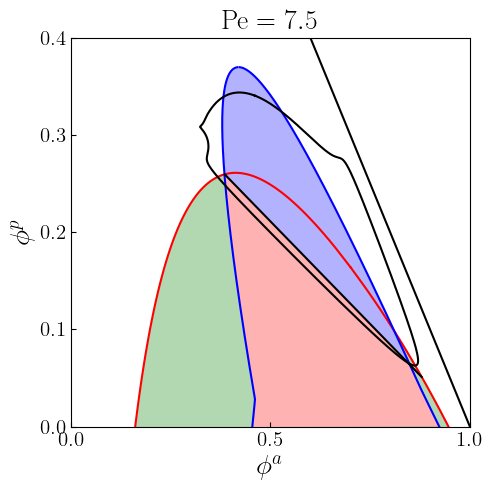

In [72]:
using PyPlot
fig, ax = subplots(1,1,figsize=(5,5))
Pe= 7.5
plot_phase(fig, ax, Pe; Lxs = [])
ax.plot(f[:,1]+f[:,2],f[:,3]; color = "black")
ax.plot(0:0.01:1,1:-0.01:0; color = "black")
display(fig)
fig_name = "phase_plot"
     @unpack ϕa, ϕp, v0, Lx, Δx = param
     pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_stretch/$(fig_name)";
     mkpath(pathname)
     filename = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_stretch/$(fig_name)/Lx=$(Lx)_Δx=$(Δx).pdf";
     PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)


In [1]:
using PyPlot
fig, ax = subplots(1,1,figsize=(5,5))
Pe= 7.5
plot_phase(fig, ax, Pe; Lxs = [])
ax.plot(f[:,1]+f[:,2],f[:,3]; color = "black")
ax.plot(0:0.01:1,1:-0.01:0; color = "black")
display(fig)
fig_name = "phase_plot"
     @unpack ϕa, ϕp, v0, Lx, Δx = param
     pathname = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_stretch/$(fig_name)";
     mkpath(pathname)
     filename = "/store/DAMTP/jm2386/Active_Lattice/plots/pm_stretch/$(fig_name)/Lx=$(Lx)_Δx=$(Δx).pdf";
     PyPlot.savefig(filename,dpi = 100, format = "pdf") #bbox_extra_artists=( ldg,)


UndefVarError: UndefVarError: plot_phase not defined

In [ ]:
function double_sol(f,param)
    @unpack Nx, Lx, Δx = param
    NNx = Int64(2*Nx)
    g = zeros(NNx,3)
    g[2:2:NNx,:] = f
    g[1:2:NNx,:] = (  f + circshift(f,(1,0))  ) /2
    Δx = Δx/2
    Nx = NNx
    @pack! param = Δx, Nx
    return g,param
end

In [ ]:
# Dispaly Profile
using PyPlot
PyPlot.close("all")
        rc("text", usetex=true)
        fig, ax = subplots(1,1,figsize=(5,5))
        @unpack Δx, Lx = param
        ax.plot(Δx:Δx:Lx, f[:,2]+f[:,1]+f[:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, f[:,1]+f[:,2]; 
        color = "red", linestyle = "--", label = L"\rho^a")
        ax.plot(Δx:Δx:Lx, f[:,3]; 
        color = "blue", linestyle = ":",label = L"\rho^p")
        ax.plot(Δx:Δx:Lx, f[:,2]-f[:,1]; 
        color = "green", linestyle = "-.", label = L"m")

        d2(x) = round(x; digits = 2)
        d4(x) = round(x; digits = 4)
        d6(x) = round(x; digits = 6)
        normf, c1, dc = f_dot(param, f)
        latex_string = latexstring("\$ t = $(d2(t)), \\phi_a = $(param["ϕa"]), \\phi_p = $(param["ϕp"]), L_2 = $(d4(normf)), c = $(d4(c1)), {\\dot c} = $(d6(dc))\$")
        ax.set_title(latex_string, fontsize = 12)
        ax.get_xaxis().set_ticks(0:10.0:Lx)
        ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.25)))
        ax.axis([0,Lx,-0.25,1.0])
        ax.tick_params(direction = "in")
        ax.legend(loc= "upper right", fontsize = 12)
        ax.set_xlabel(L"x", fontsize = 15)
display(fig)

In [ ]:
size(f), param["Δx"]

In [ ]:
f, param = double_sol(f,param)
save_interval = 0.2
@pack! param = save_interval
t,f = run_current_pde(param,save_interval, f,t)

In [ ]:
# Dispaly Profile
using PyPlot
PyPlot.close("all")
        rc("text", usetex=true)
        fig, ax = subplots(1,1,figsize=(5,5))
        @unpack Δx, Lx = param
        ax.plot(Δx:Δx:Lx, f[:,2]+f[:,1]+f[:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, f[:,1]+f[:,2]; 
        color = "red", linestyle = "--", label = L"\rho^a")
        ax.plot(Δx:Δx:Lx, f[:,3]; 
        color = "blue", linestyle = ":",label = L"\rho^p")
        ax.plot(Δx:Δx:Lx, f[:,2]-f[:,1]; 
        color = "green", linestyle = "-.", label = L"m")

        d2(x) = round(x; digits = 2)
        d4(x) = round(x; digits = 4)
        d6(x) = round(x; digits = 6)
        normf, c1, dc = f_dot(param, f)
        latex_string = latexstring("\$ t = $(d2(t)), \\phi_a = $(param["ϕa"]), \\phi_p = $(param["ϕp"]), L_2 = $(d4(normf)), c = $(d4(c1)), {\\dot c} = $(d6(dc))\$")
        ax.set_title(latex_string, fontsize = 12)
        ax.get_xaxis().set_ticks(0:10.0:Lx)
        ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.25)))
        ax.axis([0,Lx,-0.25,1.0])
        ax.tick_params(direction = "in")
        ax.legend(loc= "upper right", fontsize = 12)
        ax.set_xlabel(L"x", fontsize = 15)
display(fig)

In [ ]:
save_interval = 10.0
@pack! param = save_interval
t,f = run_current_pde(param,save_interval, f,t)

In [ ]:
# Dispaly Profile
using PyPlot
PyPlot.close("all")
        rc("text", usetex=true)
        fig, ax = subplots(1,1,figsize=(5,5))
        @unpack Δx, Lx = param
        ax.plot(Δx:Δx:Lx, f[:,2]+f[:,1]+f[:,3]; 
        color = "black", linestyle = "-", label = L"\rho")
        ax.plot(Δx:Δx:Lx, f[:,1]+f[:,2]; 
        color = "red", linestyle = "--", label = L"\rho^a")
        ax.plot(Δx:Δx:Lx, f[:,3]; 
        color = "blue", linestyle = ":",label = L"\rho^p")
        ax.plot(Δx:Δx:Lx, f[:,2]-f[:,1]; 
        color = "green", linestyle = "-.", label = L"m")

        d2(x) = round(x; digits = 2)
        d4(x) = round(x; digits = 4)
        d6(x) = round(x; digits = 6)
        normf, c1, dc = f_dot(param, f)
        latex_string = latexstring("\$ t = $(d2(t)), \\phi_a = $(param["ϕa"]), \\phi_p = $(param["ϕp"]), L_2 = $(d4(normf)), c = $(d4(c1)), {\\dot c} = $(d6(dc))\$")
        ax.set_title(latex_string, fontsize = 12)
        ax.get_xaxis().set_ticks(0:10.0:Lx)
        ax.get_yaxis().set_ticks(-0.25:0.25:1.0)
        # ax.set_xlabel(L"x", fontsize = 15)
        #ax.set_ylabel(L"m",fontsize = font, rotation = 90)
        ax.set_aspect((Lx/(1.25)))
        ax.axis([0,Lx,-0.25,1.0])
        ax.tick_params(direction = "in")
        ax.legend(loc= "upper right", fontsize = 12)
        ax.set_xlabel(L"x", fontsize = 15)
display(fig)

In [ ]:
function double_sol(param, f)
    @unpack Nx, Lx, Δx = param
    NNx = Int64(2*Nx)
    g = zeros(NNx,3)
    g[2:2:NNx,:] = f
    g[1:2:NNx,:] = (  f + circshift(f,(1,0))  ) /2
    Δx = Δx/2
    Nx = NNx
    @pack! param = Δx, Nx
    return g,param
end

function relax_sol(param,f,t; threshold = 1e-4)
    @unpack Lx,save_interval = param
    dc = threshold/Lx + 1
    while dc > threshold/Lx
        t,f = run_current_pde(param,save_interval, f,t)
        _,_,dc = f_dot(param, f)
    end
    return f, t
end

function get_stretch_param(Lx)
    param = get_grid_param(21,11)
    @unpack Nx = param
    param["save_interval"] = 100.0
    param["name"] = "soliton_stretch"
    param["Lx"] = Float64(Lx)
    param["Δx"] = Float64(Lx/Nx)
    return param
end

function densify(Lx, ΔX; save_interval = 1.0)
   
    param = get_stretch_param(Lx)
    @pack! param = save_interval

    loaded, f, t = quiet_load_last_pde(param)

    while param["Δx"] > ΔX
        f, param = double_sol(param, f)
        println("relaxing Δx = $(param["Δx"])")
        f, t = relax_sol(param,f,t)
    end

    return f,t
end


In [ ]:
param = get_stretch_param(19)
save_interval = 1.0 
@pack! param = save_interval
loaded, f, t = quiet_load_last_pde(param)

In [ ]:
t,f = run_current_pde(param,save_interval, f,t)
_,_,dc = f_dot(param, f)

In [ ]:
densify(19, 0.01; save_interval = 1.0)